# Marathi Sentiment: Baseline, Fine-tune, and Evaluation (mBERT)

This notebook fine-tunes a transformer model for Marathi sentiment classification using your dataset at `C:\LLM's_for_SA\output\balanced_mode_strict_domain.csv`. It also runs a baseline (pre-finetune) evaluation, plots confusion matrices, and generates per-class wordclouds.

Run cells top-to-bottom. If any package is missing, uncomment the install cell.

In [ ]:
# Optional: install requirements in this kernel (uncomment if needed)
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install transformers accelerate datasets scikit-learn matplotlib seaborn pandas wordcloud sentencepiece protobuf<5
# If pip complains about permissions, run the installs in a terminal for your active environment.

In [2]:
# Environment check
import sys, platform
import torch
import transformers
print(sys.version)
print('Platform:', platform.platform())
print('Torch:', torch.__version__, '| CUDA:', torch.cuda.is_available(), '| GPUs:', torch.cuda.device_count())
print('Transformers:', transformers.__version__)

3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
Torch: 2.3.1+cu121 | CUDA: True | GPUs: 1
Transformers: 4.56.1


## Configuration

In [3]:
from pathlib import Path
from datetime import datetime

# Path to your dataset
DATASET_CSV = Path(r"C:\LLM's_for_SA\output\balanced_mode_strict_domain.csv")

# Choose a model. 'xlm-roberta-base' is robust and uses safetensors.
# You can try 'ai4bharat/indic-bert' as well, but some environments gate weights or require specific versions.
MODEL_NAME = 'bert-base-multilingual-cased'  # swapped model

MAX_LENGTH = 192
BATCH_SIZE = 16
EPOCHS = 2  # increase to 3-5 for better results if time allows
LR = 2e-5
SEED = 42

# Outputs will be stored under this directory
OUTPUT_ROOT = Path.cwd().parent / 'results' / 'notebook_run'
RUN_DIR = OUTPUT_ROOT / datetime.now().strftime('%Y%m%d_%H%M%S')
RUN_DIR.mkdir(parents=True, exist_ok=True)
RUN_DIR

WindowsPath("c:/LLM's_for_SA/results/notebook_run/20250917_162312")

## Load data and create splits

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

LABEL_ORDER = {'negative': 0, 'neutral': 1, 'positive': 2}
ID2LABEL = {v: k for k, v in LABEL_ORDER.items()}

df = pd.read_csv(DATASET_CSV)
assert 'text' in df.columns, f"Expected 'text' in columns: {df.columns.tolist()}"

if 'label_raw' in df.columns:
    def map_raw(x):
        return {-1: 0, 0: 1, 1: 2}[int(x)]
    df['label_id'] = df['label_raw'].apply(map_raw)
elif 'label' in df.columns:
    df['label_id'] = df['label'].astype(str).str.lower().map(LABEL_ORDER).astype(int)
else:
    raise ValueError("No usable label column found. Need 'label_raw' or 'label'.")
print(df['label_id'])

X = df['text'].values
y = df['label_id'].values

# 10% test, 10% val of total (i.e., split twice with stratification)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
train_val_idx, test_idx = next(sss1.split(X, y))
df_train_val = df.iloc[train_val_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

X_tv = df_train_val['text'].values
y_tv = df_train_val['label_id'].values
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=SEED)  # ~10% of total
train_idx, val_idx = next(sss2.split(X_tv, y_tv))
df_train = df_train_val.iloc[train_idx].reset_index(drop=True)
df_val = df_train_val.iloc[val_idx].reset_index(drop=True)

split_dir = RUN_DIR / 'splits'
split_dir.mkdir(parents=True, exist_ok=True)
df_train.to_csv(split_dir / 'train.csv', index=False)
df_val.to_csv(split_dir / 'val.csv', index=False)
df_test.to_csv(split_dir / 'test.csv', index=False)
len(df_train), len(df_val), len(df_test)

0        0
1        2
2        2
3        2
4        0
        ..
29995    2
29996    0
29997    0
29998    1
29999    2
Name: label_id, Length: 30000, dtype: int64


(24000, 3000, 3000)

## Dataset class and utilities

In [5]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns, matplotlib.pyplot as plt

class TextClsDS(Dataset):
    def __init__(self, df, tokenizer, text_col='text', label_col='label_id', max_length=MAX_LENGTH):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.label_col = label_col
        self.max_length = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        enc = self.tokenizer(str(r[self.text_col]), truncation=True, max_length=self.max_length)
        enc['labels'] = int(r[self.label_col])
        return enc

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    import numpy as np
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {'accuracy': acc, 'precision_macro': p, 'recall_macro': r, 'f1_macro': f1}

def plot_cm(y_true, y_pred, title, out_png):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    plt.figure(figsize=(5.5,4.5), dpi=150)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[ID2LABEL[i] for i in [0,1,2]], yticklabels=[ID2LABEL[i] for i in [0,1,2]])
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title); plt.tight_layout()
    plt.savefig(out_png)
    # Also display inline in the notebook
    plt.show()
    plt.close()

def eval_model(model, tokenizer, dataset, device, batch_size=64):
    coll = DataCollatorWithPadding(tokenizer=tokenizer)
    dl = DataLoader(dataset, batch_size=batch_size, collate_fn=coll)
    model.to(device); model.eval()
    ys, ps = [], []
    import numpy as np, torch
    with torch.no_grad():
        for batch in dl:
            labels = batch.get('labels')
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            logits = model(**inputs).logits.detach().cpu().numpy()
            if labels is None: continue
            ys.extend(labels.detach().cpu().numpy().tolist())
            ps.extend(np.argmax(logits, axis=-1).tolist())
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
    import numpy as np
    ys, ps = np.array(ys), np.array(ps)
    acc = accuracy_score(ys, ps)
    p, r, f1, _ = precision_recall_fscore_support(ys, ps, average='macro', zero_division=0)
    rep = classification_report(ys, ps, target_names=[ID2LABEL[i] for i in [0,1,2]], zero_division=0, output_dict=True)
    return {'accuracy': acc, 'precision_macro': p, 'recall_macro': r, 'f1_macro': f1, 'report': rep, 'y_true': ys, 'y_pred': ps}

## Load model and tokenizer

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=ID2LABEL, label2id=LABEL_ORDER, use_safetensors=True
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

## Baseline evaluation (before fine-tuning)

c:\Users\ashpa\miniconda3\envs\marx\Lib\site-packages\transformers\models\bert\modeling_bert.py:412: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Baseline metrics:
  Accuracy:  0.3443
  Precision: 0.3105
  Recall:    0.3443
  F1-score:  0.2565


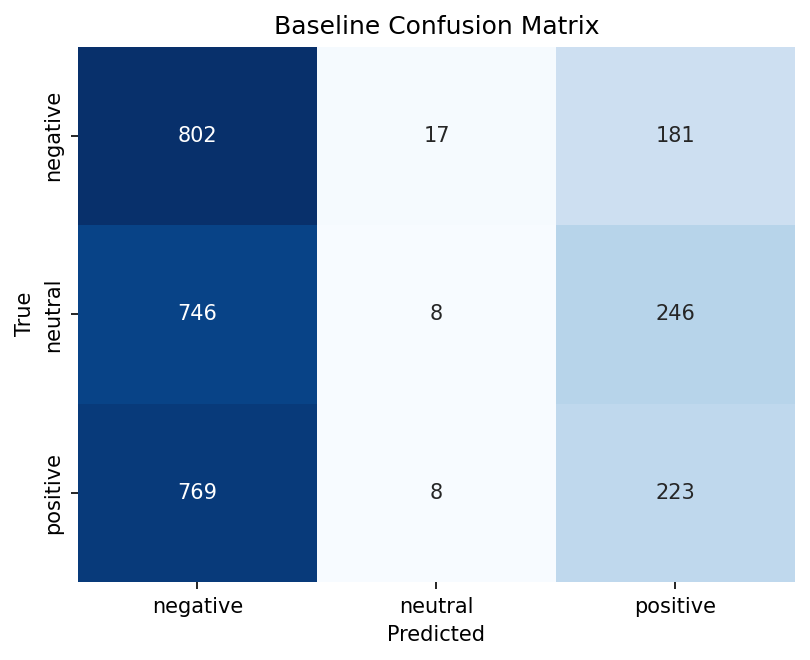

(0.3443333333333333, 0.2564537960610234)

In [7]:
train_ds = TextClsDS(df_train, tokenizer)
val_ds = TextClsDS(df_val, tokenizer)
test_ds = TextClsDS(df_test, tokenizer)

baseline = eval_model(model, tokenizer, test_ds, device)
baseline_out = RUN_DIR / 'baseline_metrics.json'
import json
with open(baseline_out, 'w', encoding='utf-8') as f:
    json.dump({k:v for k,v in baseline.items() if k not in ['y_true','y_pred']}, f, ensure_ascii=False, indent=2)

# Print metrics nicely
print('Baseline metrics:')
print(f"  Accuracy:  {baseline['accuracy']:.4f}")
print(f"  Precision: {baseline['precision_macro']:.4f}")
print(f"  Recall:    {baseline['recall_macro']:.4f}")
print(f"  F1-score:  {baseline['f1_macro']:.4f}")

# Plot + show confusion matrix
plot_cm(baseline['y_true'], baseline['y_pred'], 'Baseline Confusion Matrix', RUN_DIR / 'cm_baseline.png')
(baseline['accuracy'], baseline['f1_macro'])

Predicted classes present: positive, negative, neutral
Saved c:\LLM's_for_SA\results\notebook_run\20250917_162312\wordclouds\balanced_sentiment_wordcloud_before.png
Saved c:\LLM's_for_SA\results\notebook_run\20250917_162312\wordclouds\balanced_sentiment_wordcloud_before.png


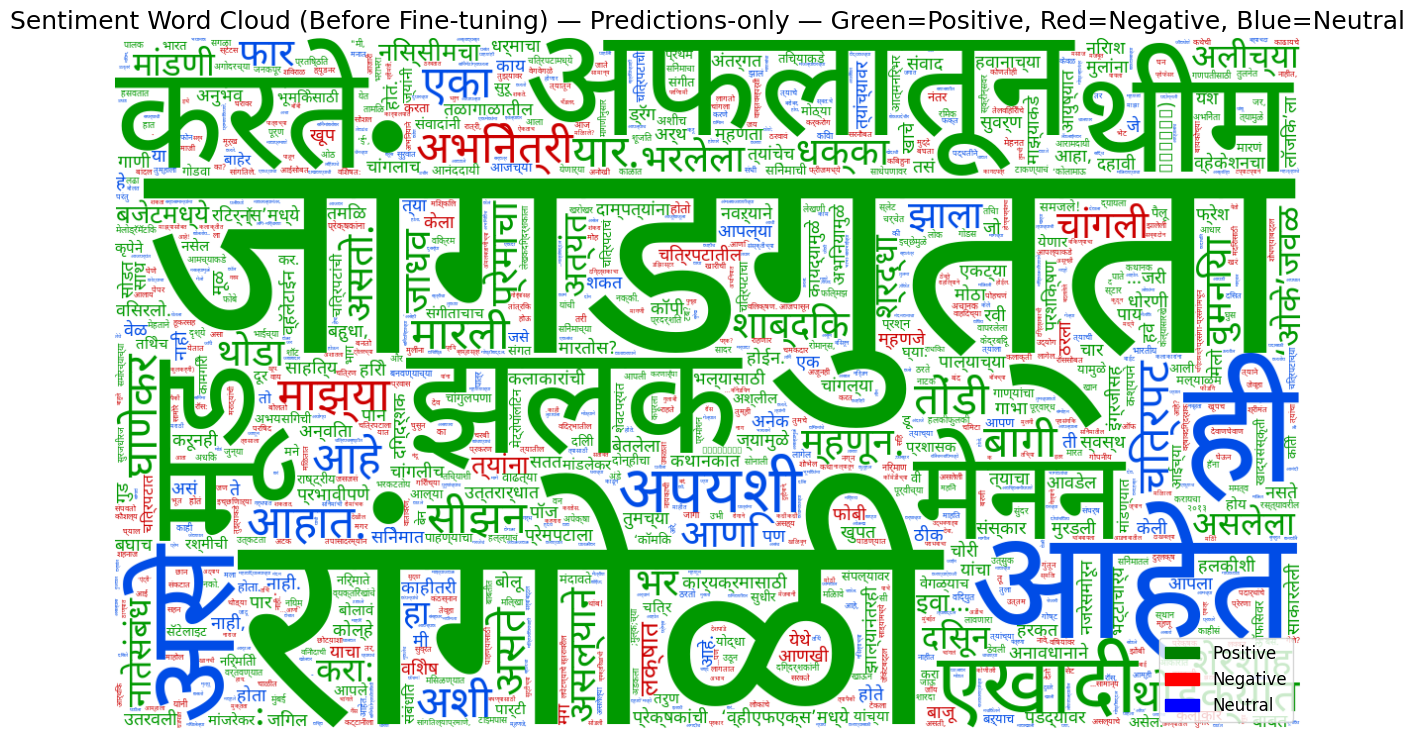

In [8]:
# Predictions-only BEFORE wordcloud (no ground-truth fallback)
# Uses only baseline['y_pred'] to color tokens; result may be single-color if model predicts one class
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS
try:
    import requests
except Exception:
    requests = None

# 1) Ensure a Devanagari-capable font is available
local_font = Path.cwd().parent / 'fonts' / 'NotoSansDevanagari-Regular.ttf'
font_path = local_font if local_font.exists() else (Path('NotoSansDevanagari-Regular.ttf') if Path('NotoSansDevanagari-Regular.ttf').exists() else None)
if font_path is None and requests is not None:
    try:
        url = 'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf'
        r = requests.get(url); r.raise_for_status()
        Path('NotoSansDevanagari-Regular.ttf').write_bytes(r.content)
        font_path = Path('NotoSansDevanagari-Regular.ttf')
        print('Font downloaded successfully.')
    except Exception as e:
        print('Font download failed; using default font:', e)
        font_path = None

# 2) Strictly use baseline predictions
import pandas as pd
if not (('baseline' in globals()) and isinstance(baseline, dict) and 'y_pred' in baseline and 'df_test' in globals() and len(baseline['y_pred']) == len(df_test)):
    print('Predictions-only BEFORE wordcloud skipped: baseline predictions not available or length mismatch.')
else:
    pred_labels = pd.Series([ID2LABEL[int(i)] for i in baseline['y_pred']])
    text_col = 'cleaned_text' if 'cleaned_text' in df_test.columns else 'text'

    def toks(label_name):
        combined = ' '.join(df_test[pred_labels == label_name][text_col].astype(str).tolist())
        return [w.strip() for w in combined.split() if w.strip()]

    pos_words = toks('positive')
    neg_words = toks('negative')
    neu_words = toks('neutral')
    present = [lbl for lbl, lst in [('positive', pos_words), ('negative', neg_words), ('neutral', neu_words)] if len(lst) > 0]
    print('Predicted classes present:', ', '.join(present) if present else 'none')

    # If fewer than two classes have tokens, sample from whatever is available (may be one color)
    available_lists = [lst for lst in [pos_words, neg_words, neu_words] if len(lst) > 0]
    if not available_lists:
        print('Skipping BEFORE wordcloud: no tokens in predictions.')
    else:
        # Sample equally across available classes to avoid one dominating, but no artificial balancing across missing ones
        min_len = min(len(lst) for lst in available_lists)
        random.seed(42)
        pos_sample = random.sample(pos_words, min_len) if len(pos_words) >= min_len else []
        neg_sample = random.sample(neg_words, min_len) if len(neg_words) >= min_len else []
        neu_sample = random.sample(neu_words, min_len) if len(neu_words) >= min_len else []

        word_frequencies, word_sentiment = {}, {}
        for w in pos_sample: word_frequencies[w] = 1; word_sentiment[w] = 'positive'
        for w in neg_sample: word_frequencies[w] = 1; word_sentiment[w] = 'negative'
        for w in neu_sample: word_frequencies[w] = 1; word_sentiment[w] = 'neutral'

        def color_func(word, **kwargs):
            s = word_sentiment.get(word, 'neutral')
            return ('hsl(120, 100%, 30%)' if s == 'positive' else
                    'hsl(0, 100%, 40%)' if s == 'negative' else
                    'hsl(220, 100%, 45%)')

        wc = WordCloud(
            width=1200, height=700, background_color='white',
            font_path=str(font_path) if font_path else None,
            stopwords=STOPWORDS, prefer_horizontal=0.9, max_words=3 * min_len,
            color_func=color_func
        ).generate_from_frequencies(word_frequencies)

        out_wc_dir = RUN_DIR / 'wordclouds'; out_wc_dir.mkdir(parents=True, exist_ok=True)
        out_png = out_wc_dir / 'balanced_sentiment_wordcloud_before.png'

        plt.figure(figsize=(16, 9))
        plt.imshow(wc, interpolation='bilinear'); plt.axis('off')
        title_suffix = ' — Predictions-only'
        plt.title('Sentiment Word Cloud (Before Fine-tuning)' + title_suffix + ' — Green=Positive, Red=Negative, Blue=Neutral', fontsize=18)
        legend_handles = []
        if pos_sample: legend_handles.append(mpatches.Patch(color='green', label='Positive'))
        if neg_sample: legend_handles.append(mpatches.Patch(color='red', label='Negative'))
        if neu_sample: legend_handles.append(mpatches.Patch(color='blue', label='Neutral'))
        if legend_handles:
            plt.legend(handles=legend_handles, loc='lower right', fontsize=12)
        try:
            plt.savefig(out_png, dpi=150, bbox_inches='tight'); print('Saved', out_png)
        except Exception as e:
            print('Could not save BEFORE wordcloud:', e)
        plt.show()

## Fine-tune

In [9]:
import torch
import numpy as np
import inspect, transformers
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Build TrainingArguments kwargs compatibly across transformers versions
sig = inspect.signature(TrainingArguments.__init__)
params = sig.parameters
kw = {
    'output_dir': str(RUN_DIR / 'checkpoints'),
    'num_train_epochs': EPOCHS,
    'learning_rate': LR,
}
# Batch size params (older versions used per_gpu_*)
if 'per_device_train_batch_size' in params:
    kw['per_device_train_batch_size'] = BATCH_SIZE
    kw['per_device_eval_batch_size'] = max(8, BATCH_SIZE)
elif 'per_gpu_train_batch_size' in params:
    kw['per_gpu_train_batch_size'] = BATCH_SIZE
    kw['per_gpu_eval_batch_size'] = max(8, BATCH_SIZE)
# Logging
if 'logging_steps' in params:
    kw['logging_steps'] = 50
if 'logging_strategy' in params:
    kw['logging_strategy'] = 'steps'

# Evaluation and saving strategy (ensure they match if we enable best model at end)
eval_key = 'evaluation_strategy' if 'evaluation_strategy' in params else ('eval_strategy' if 'eval_strategy' in params else None)
save_key = 'save_strategy' if 'save_strategy' in params else None
if eval_key is not None:
    kw[eval_key] = 'epoch'
    if save_key is not None:
        kw[save_key] = 'epoch'
elif 'evaluate_during_training' in params:
    kw['evaluate_during_training'] = True

# Reproducibility
if 'seed' in params:
    kw['seed'] = SEED
# Mixed precision
if 'fp16' in params:
    kw['fp16'] = torch.cuda.is_available()
# Reporting
if 'report_to' in params:
    kw['report_to'] = ['none']

# Best model selection only if both eval and save strategy can be set consistently
if ('load_best_model_at_end' in params) and (eval_key is not None) and (save_key is not None):
    kw['load_best_model_at_end'] = True
    if 'metric_for_best_model' in params:
        kw['metric_for_best_model'] = 'f1_macro'
    if 'greater_is_better' in params:
        kw['greater_is_better'] = True

args = TrainingArguments(**kw)

def _metrics(eval_pred):
    # Support both tuple and EvalPrediction objects
    try:
        logits, labels = eval_pred
    except Exception:
        logits, labels = eval_pred.predictions, eval_pred.label_ids
    # Some models return a tuple for predictions
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    # Convert torch tensors to numpy if needed
    if hasattr(logits, 'detach'):
        logits = logits.detach().cpu().numpy()
    if hasattr(labels, 'detach'):
        labels = labels.detach().cpu().numpy()
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {'accuracy': acc, 'precision_macro': p, 'recall_macro': r, 'f1_macro': f1}

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=_metrics,
)
train_res = trainer.train()
trainer.save_model(str(RUN_DIR / 'model'))
tokenizer.save_pretrained(str(RUN_DIR / 'model'))
'done'

C:\Users\ashpa\AppData\Local\Temp\ipykernel_19684\1577562848.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.741000,0.634494,0.726000,0.733297,0.726000,0.723239
2,0.575900,0.618596,0.750000,0.749158,0.750000,0.747231


'done'

In [14]:
print(RUN_DIR)

c:\LLM's_for_SA\results\notebook_run\20250917_162312


## Evaluation after fine-tuning

After fine-tuning metrics:
  Accuracy:  0.7420
  Precision: 0.7414
  Recall:    0.7420
  F1-score:  0.7401


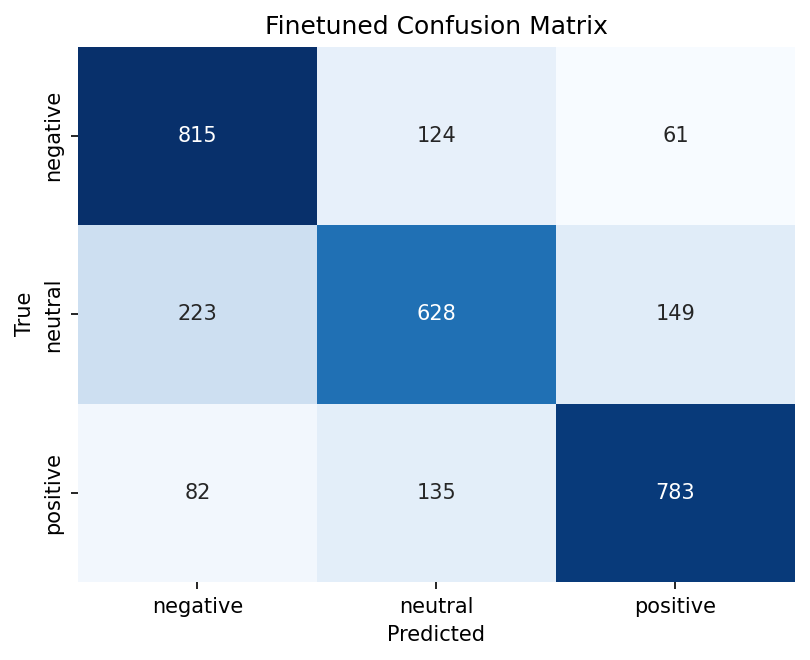

((0.3443333333333333, 0.742), (0.2564537960610234, 0.7400749444070601))

In [10]:
after = eval_model(model, tokenizer, test_ds, device)
with open(RUN_DIR / 'finetuned_metrics.json', 'w', encoding='utf-8') as f:
    json.dump({k:v for k,v in after.items() if k not in ['y_true','y_pred']}, f, ensure_ascii=False, indent=2)

# Print metrics nicely
print('After fine-tuning metrics:')
print(f"  Accuracy:  {after['accuracy']:.4f}")
print(f"  Precision: {after['precision_macro']:.4f}")
print(f"  Recall:    {after['recall_macro']:.4f}")
print(f"  F1-score:  {after['f1_macro']:.4f}")

# Plot + show confusion matrix
plot_cm(after['y_true'], after['y_pred'], 'Finetuned Confusion Matrix', RUN_DIR / 'cm_finetuned.png')
((baseline['accuracy'], after['accuracy']), (baseline['f1_macro'], after['f1_macro']))

## Summary

In [11]:
summary = {
    'model': MODEL_NAME,
    'device': str(device),
    'dataset': str(DATASET_CSV),
    'outputs': str(RUN_DIR.resolve()),
    'baseline': {k: baseline[k] for k in ['accuracy','precision_macro','recall_macro','f1_macro']},
    'finetuned': {k: after[k] for k in ['accuracy','precision_macro','recall_macro','f1_macro']},
}
import json
with open(RUN_DIR / 'summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
summary

{'model': 'bert-base-multilingual-cased',
 'device': 'cuda',
 'dataset': "C:\\LLM's_for_SA\\output\\balanced_mode_strict_domain.csv",
 'outputs': "C:\\LLM's_for_SA\\results\\notebook_run\\20250917_162312",
 'baseline': {'accuracy': 0.3443333333333333,
  'precision_macro': 0.31054613731350894,
  'recall_macro': 0.3443333333333334,
  'f1_macro': 0.2564537960610234},
 'finetuned': {'accuracy': 0.742,
  'precision_macro': 0.7414009061578902,
  'recall_macro': 0.742,
  'f1_macro': 0.7400749444070601}}

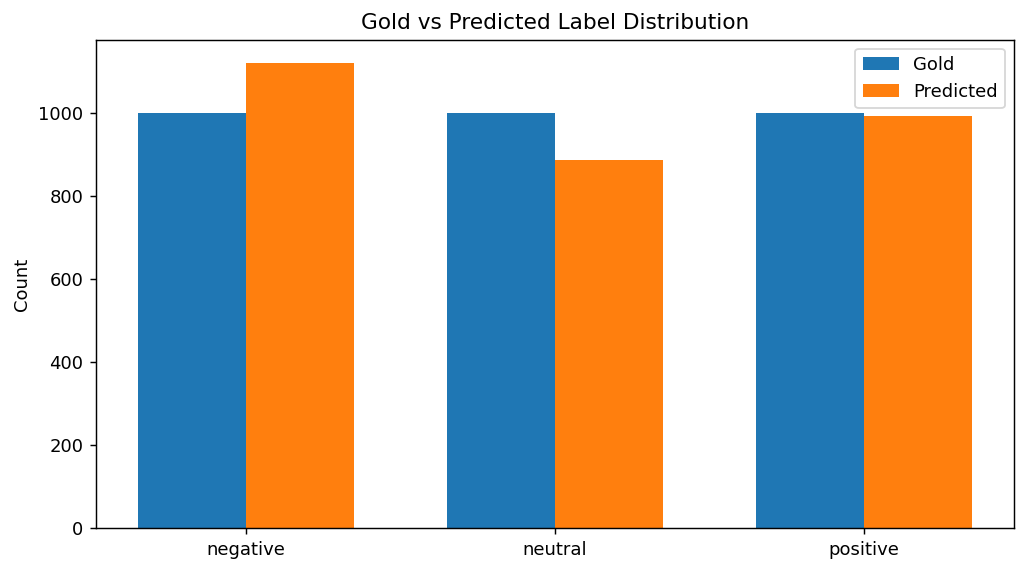

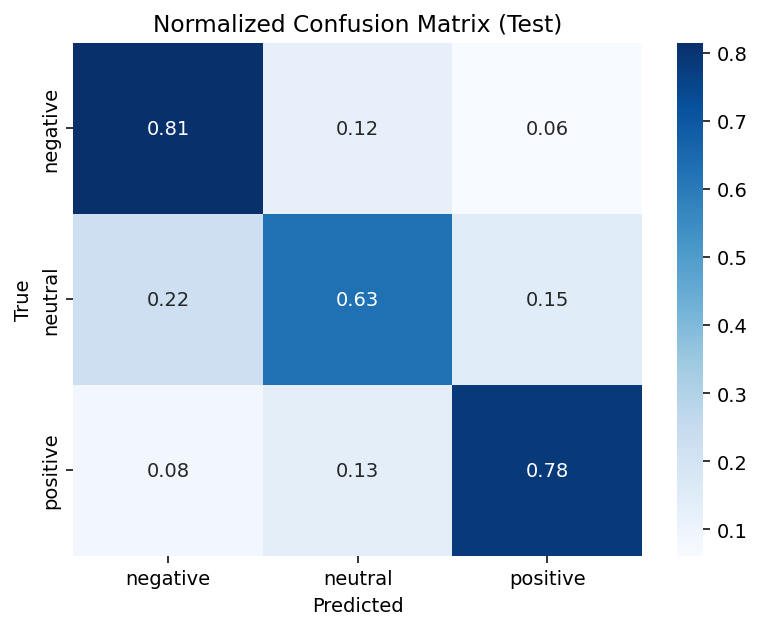

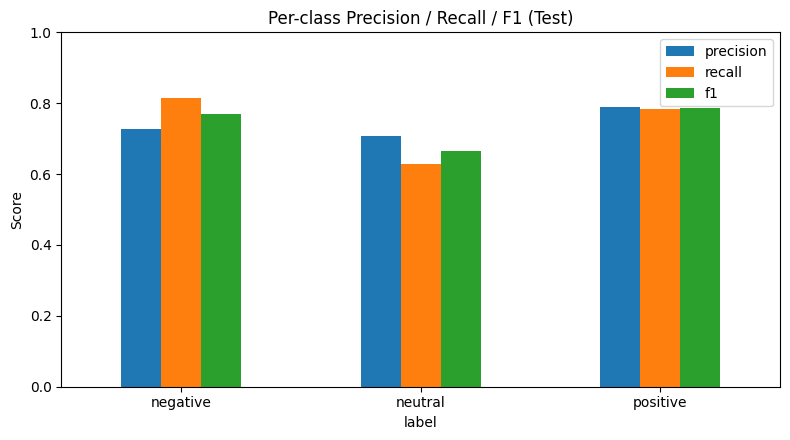

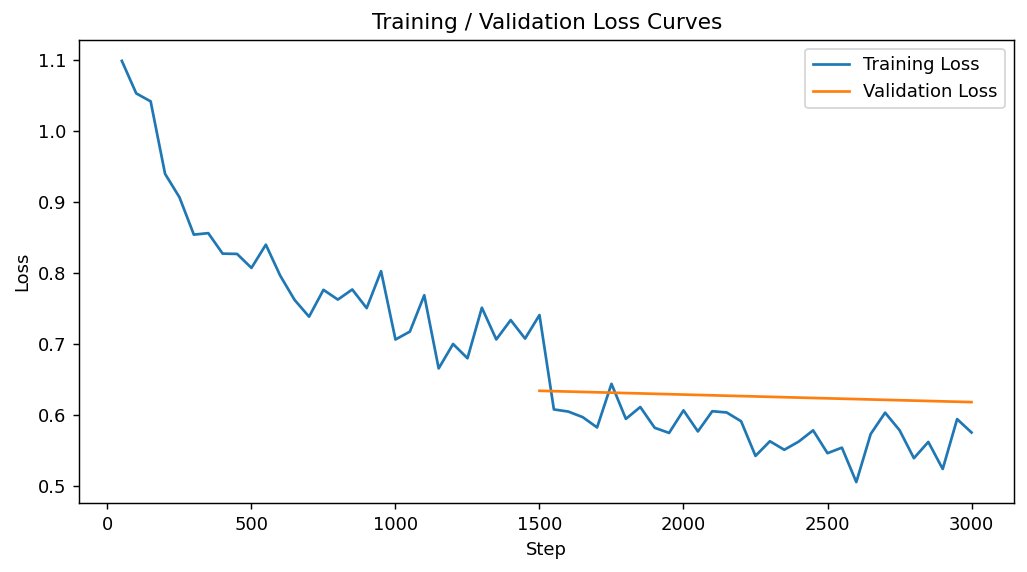

In [12]:
# Visual comparisons and extra plots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Gold vs Predicted label distribution on test set
labels = [ID2LABEL[i] for i in [0,1,2]]
true_counts = pd.Series(after['y_true']).value_counts().reindex([0,1,2]).fillna(0).astype(int)
pred_counts = pd.Series(after['y_pred']).value_counts().reindex([0,1,2]).fillna(0).astype(int)

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(8,4.5), dpi=130)
plt.bar(x - width/2, true_counts.values, width, label='Gold')
plt.bar(x + width/2, pred_counts.values, width, label='Predicted')
plt.xticks(x, labels)
plt.ylabel('Count')
plt.title('Gold vs Predicted Label Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Normalized confusion matrix (row-normalized)
cm = confusion_matrix(after['y_true'], after['y_pred'], labels=[0,1,2])
cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-9)
plt.figure(figsize=(5.8,4.6), dpi=140)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# 3) Per-class precision/recall/F1 bar chart (from classification report)
report = after['report']
per_class = pd.DataFrame({
    'label': labels,
    'precision': [report[l]['precision'] for l in labels],
    'recall':    [report[l]['recall'] for l in labels],
    'f1':        [report[l]['f1-score'] for l in labels],
})
per_class = per_class.set_index('label')
ax = per_class.plot(kind='bar', figsize=(8,4.5), rot=0)
ax.set_ylim(0, 1.0)
ax.set_title('Per-class Precision / Recall / F1 (Test)')
ax.set_ylabel('Score')
plt.tight_layout()
plt.show()

# 4) Optional: Training curves if available
try:
    if 'train_res' in globals() and hasattr(train_res, 'metrics'):
        # Some Trainer versions provide trainer.state.log_history for detailed steps
        hist = getattr(trainer.state, 'log_history', [])
        train_steps, train_losses, eval_steps, eval_losses = [], [], [], []
        for e in hist:
            if 'loss' in e and 'epoch' in e:
                train_steps.append(e.get('step', len(train_steps)))
                train_losses.append(e['loss'])
            if 'eval_loss' in e and 'epoch' in e:
                eval_steps.append(e.get('step', len(eval_steps)))
                eval_losses.append(e['eval_loss'])
        if train_losses:
            plt.figure(figsize=(8,4.5), dpi=130)
            plt.plot(train_steps, train_losses, label='Training Loss')
            if eval_losses:
                plt.plot(eval_steps, eval_losses, label='Validation Loss')
            plt.xlabel('Step')
            plt.ylabel('Loss')
            plt.title('Training / Validation Loss Curves')
            plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print('Training curve plot skipped:', e)

Using predicted labels (after) for wordcloud.
Saved c:\LLM's_for_SA\results\notebook_run\20250917_162312\wordclouds\balanced_sentiment_wordcloud_after.png
Saved c:\LLM's_for_SA\results\notebook_run\20250917_162312\wordclouds\balanced_sentiment_wordcloud_after.png


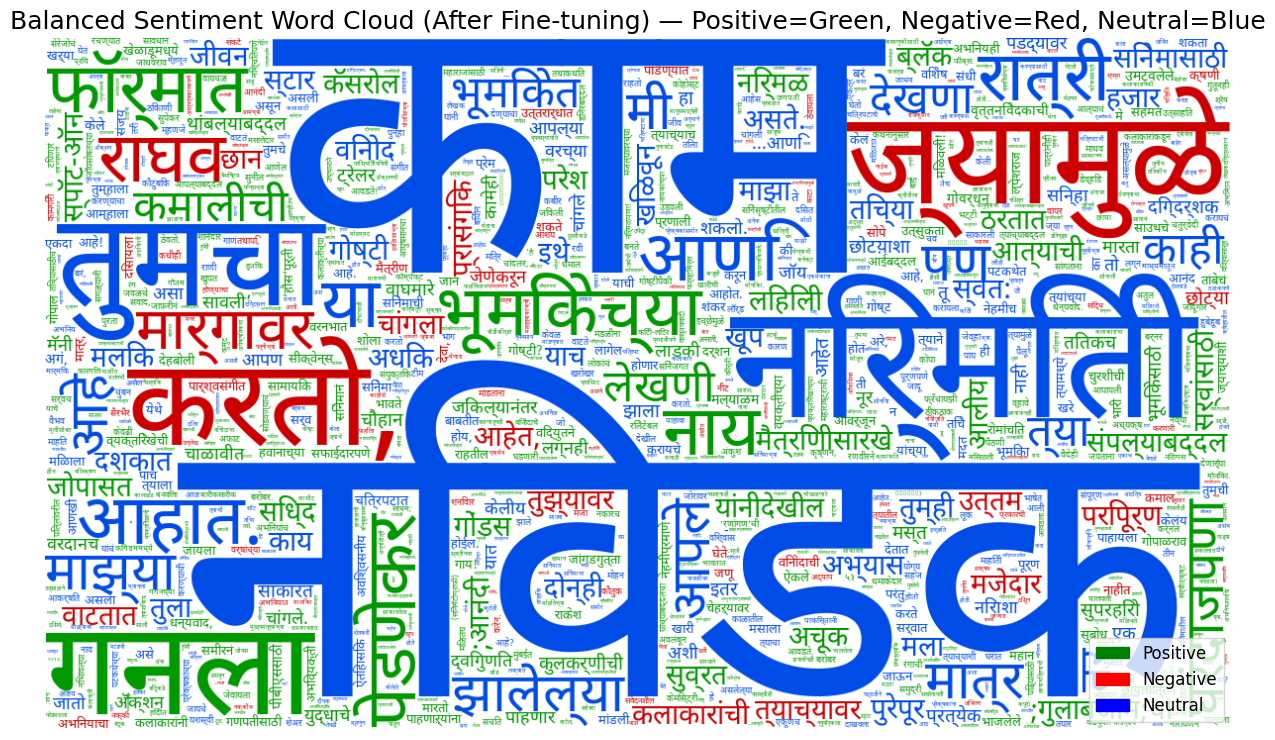

In [13]:
# Balanced, color-coded sentiment WordCloud after fine-tuning (predictions preferred)
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS
try:
    import requests
except Exception:
    requests = None

# 1) Ensure a Devanagari-capable font is available (prefer local fonts folder, else try one-time download)
local_font = Path.cwd().parent / 'fonts' / 'NotoSansDevanagari-Regular.ttf'
font_path = None
if local_font.exists():
    font_path = local_font
else:
    here_font = Path('NotoSansDevanagari-Regular.ttf')
    font_path = here_font if here_font.exists() else None
    if font_path is None and requests is not None:
        try:
            url = 'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf'
            print(f'Downloading font from {url}...')
            r = requests.get(url)
            r.raise_for_status()
            here_font.write_bytes(r.content)
            font_path = here_font
            print('Font downloaded successfully.')
        except Exception as e:
            print('Font download failed; falling back to default font:', e)
            font_path = None

# 2) Build review texts using predictions if available (after), else ground truth
# Requires: after (with y_pred/y_true), df_test/df, ID2LABEL, RUN_DIR already defined by earlier cells
def collect_by_label_texts(df_like, label_series_str):
    text_col = 'cleaned_text' if 'cleaned_text' in df_like.columns else 'text'
    pos = ' '.join(df_like[label_series_str == 'positive'][text_col].astype(str).tolist())
    neg = ' '.join(df_like[label_series_str == 'negative'][text_col].astype(str).tolist())
    neu = ' '.join(df_like[label_series_str == 'neutral'][text_col].astype(str).tolist())
    return pos, neg, neu

positive_reviews = negative_reviews = neutral_reviews = None
try:
    import pandas as pd
    if ('after' in globals()) and isinstance(after, dict) and 'y_pred' in after and 'y_true' in after:
        if 'df_test' in globals() and len(after['y_pred']) == len(df_test):
            pred_labels = pd.Series([ID2LABEL[int(i)] for i in after['y_pred']])
            positive_reviews, negative_reviews, neutral_reviews = collect_by_label_texts(df_test, pred_labels)
            print('Using predicted labels (after) for wordcloud.')
except Exception as e:
    print('Prediction-based wordcloud fallback:', e)

if not positive_reviews or not negative_reviews or not neutral_reviews:
    import pandas as pd
    src_df = df_test if 'df_test' in globals() else (df if 'df' in globals() else None)
    if src_df is not None and 'label_id' in src_df.columns:
        gt_labels = pd.Series([ID2LABEL[int(i)] for i in src_df['label_id'].astype(int)])
        positive_reviews, negative_reviews, neutral_reviews = collect_by_label_texts(src_df, gt_labels)
        print('Using ground-truth labels for wordcloud.')
    else:
        print('No suitable dataframe found for wordcloud.')
        positive_reviews = negative_reviews = neutral_reviews = ''

# 3) Tokenize and balance class representation by sampling equal numbers of tokens
pos_words = [w.strip() for w in positive_reviews.split() if w.strip()]
neg_words = [w.strip() for w in negative_reviews.split() if w.strip()]
neu_words = [w.strip() for w in neutral_reviews.split() if w.strip()]

min_len = min(len(pos_words), len(neg_words), len(neu_words))
if min_len == 0:
    print('Skipping wordcloud: one or more sentiments have zero tokens.')
else:
    random.seed(42)
    pos_sample = random.sample(pos_words, min_len)
    neg_sample = random.sample(neg_words, min_len)
    neu_sample = random.sample(neu_words, min_len)

    # Equalize frequencies (all sampled words get freq=1)
    word_frequencies, word_sentiment = {}, {}
    for w in pos_sample:
        word_frequencies[w] = 1; word_sentiment[w] = 'positive'
    for w in neg_sample:
        word_frequencies[w] = 1; word_sentiment[w] = 'negative'
    for w in neu_sample:
        word_frequencies[w] = 1; word_sentiment[w] = 'neutral'

    def color_func(word, **kwargs):
        s = word_sentiment.get(word, 'neutral')
        if s == 'positive':
            return 'hsl(120, 100%, 30%)'  # green
        elif s == 'negative':
            return 'hsl(0, 100%, 40%)'    # red
        else:
            return 'hsl(220, 100%, 45%)'  # blue

    wc = WordCloud(
        width=1200, height=700, background_color='white',
        font_path=str(font_path) if font_path else None,
        stopwords=STOPWORDS, prefer_horizontal=0.9, max_words=3 * min_len,
        color_func=color_func
    ).generate_from_frequencies(word_frequencies)

    out_wc_dir = RUN_DIR / 'wordclouds'
    out_wc_dir.mkdir(parents=True, exist_ok=True)
    out_png = out_wc_dir / 'balanced_sentiment_wordcloud_after.png'

    plt.figure(figsize=(16, 9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Balanced Sentiment Word Cloud (After Fine-tuning) — Positive=Green, Negative=Red, Neutral=Blue', fontsize=18)
    plt.legend(
        handles=[
            mpatches.Patch(color='green', label='Positive'),
            mpatches.Patch(color='red', label='Negative'),
            mpatches.Patch(color='blue', label='Neutral')
        ],
        loc='lower right', fontsize=12
    )
    try:
        plt.savefig(out_png, dpi=150, bbox_inches='tight')
        print('Saved', out_png)
    except Exception as e:
        print('Could not save wordcloud:', e)
    plt.show()


In [ ]:
# Create variant notebooks for other models (mBERT & MuRIL)
import json, copy
from pathlib import Path

src = Path(r"C:\LLM's_for_SA\LLMs_testing\marathi_finetune_and_eval.ipynb")
dest_mbert = Path(r"C:\LLM's_for_SA\LLMs_testing\marathi_finetune_and_eval_mbert.ipynb")
dest_muril = Path(r"C:\LLM's_for_SA\LLMs_testing\marathi_finetune_and_eval_muril.ipynb")

with open(src, 'r', encoding='utf-8') as f:
    nb = json.load(f)

def make_variant(nb_src, new_model, title_suffix, out_path):
    nb2 = copy.deepcopy(nb_src)
    # 1) Swap MODEL_NAME in the configuration cell
    for cell in nb2.get('cells', []):
        if cell.get('cell_type') == 'code':
            src_lines = cell.get('source', [])
            if any('MODEL_NAME' in str(line) for line in src_lines):
                new_lines = []
                for line in src_lines:
                    if line.strip().startswith('MODEL_NAME'):
                        new_lines.append(f"MODEL_NAME = '{new_model}'  # swapped model\n")
                    else:
                        new_lines.append(line)
                cell['source'] = new_lines
                break
    # 2) Update the title cell to include the model name for clarity
    for cell in nb2.get('cells', []):
        if cell.get('cell_type') == 'markdown':
            src_md = cell.get('source', [])
            if src_md and str(src_md[0]).lstrip().startswith('#'):
                if title_suffix not in src_md[0]:
                    src_md[0] = src_md[0].rstrip() + f" ({title_suffix})\n"
                break
    # 3) Write the new notebook
    with open(out_path, 'w', encoding='utf-8') as wf:
        json.dump(nb2, wf, ensure_ascii=False, indent=2)

make_variant(nb, 'bert-base-multilingual-cased', 'mBERT', dest_mbert)
make_variant(nb, 'google/muril-base-cased', 'MuRIL', dest_muril)
print('Created:', dest_mbert, 'and', dest_muril)